In [55]:
import pandas as pd
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
import os

base_dir = "/content/drive/MyDrive/Voiseed_task/LibriSpeech"
audio_dir = os.path.join(base_dir, "dev-clean/")
speaker_file = os.path.join(base_dir, "SPEAKERS.TXT")

In [58]:
speakers_file = "/content/drive/MyDrive/Voiseed_task/LibriSpeech/SPEAKERS.TXT"

with open(speakers_file, "r") as f:
    lines = [line.strip() for line in f.readlines() if not line.startswith(";")]

In [59]:
# Extract speaker information (ID, gender, subset) from text lines
speaker_data = []
for line in lines:
    parts = line.split("|")
    speaker_id = parts[0].strip()
    gender = parts[1].strip()
    subset = parts[2].strip()
    speaker_data.append((speaker_id, gender, subset))

# Convert extracted data into a structured DataFrame
df_speakers = pd.DataFrame(speaker_data, columns=["Speaker_ID", "Gender", "Subset"])

# Filter only speakers from the "dev-clean" subset
df_dev_clean = df_speakers[df_speakers["Subset"] == "dev-clean"]

# Select a balanced subset: 9 male and 9 female speakers
df_male = df_dev_clean[df_dev_clean["Gender"] == "M"].head(9)
df_female = df_dev_clean[df_dev_clean["Gender"] == "F"].head(9)
df_sampled = pd.concat([df_male, df_female]).reset_index(drop=True)

# Display the final sampled dataset
display(df_sampled)

,Speaker_ID,Gender,Subset
0,174,M,dev-clean
1,251,M,dev-clean
2,422,M,dev-clean
3,652,M,dev-clean
4,777,M,dev-clean
5,1272,M,dev-clean
6,2078,M,dev-clean
7,2086,M,dev-clean
8,2428,M,dev-clean
9,84,F,dev-clean


In [60]:
audio_dir = "/content/drive/MyDrive/Voiseed_task/LibriSpeech/dev-clean"

# Parameters for MFCC extraction
n_mfcc = 13  # Number of MFCC features
sr = 16000  # Sampling rate for audio processing

def extract_mfcc(file_path, n_mfcc=n_mfcc, sr=sr):
    """
    Extracts MFCC features from an audio file.
    - Loads the audio file with the specified sampling rate.
    - Computes MFCC features.
    - Returns the mean of MFCCs across time frames (fixed-size representation).
    """
    w, sr = librosa.load(file_path, sr=sr)
    mfccs = librosa.feature.mfcc(y=w, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs, axis=1)

In [7]:
features = []
labels = []

# Iterate through the sampled dataset to process each speaker's audio files
for _, row in df_sampled.iterrows():
    speaker_id = row["Speaker_ID"]
    gender = row["Gender"]
    speaker_folder = os.path.join(audio_dir, str(speaker_id))
    # Iterate through chapters within the speaker's folder
    for chapter in os.listdir(speaker_folder):
        chapter_folder = os.path.join(speaker_folder, chapter)
        # Iterate through audio files in the chapter
        for file in os.listdir(chapter_folder):
            if file.endswith(".flac"):
                file_path = os.path.join(chapter_folder, file)
                mfcc = extract_mfcc(file_path, n_mfcc=n_mfcc)
                features.append(mfcc)
                labels.append(gender)

print(labels[:10])
X = np.array(features)
y = np.array(labels)

print(f"Extracted MFCC features shape: {X.shape}, Labels shape: {y.shape}")

['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M']
Extracted MFCC features shape: (349, 13), Labels shape: (349,)


In [61]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [62]:
print(X_scaled)

[[-0.5396001  -1.0218719  -1.6416079  ... -0.977922   -0.13772778
   1.1007932 ]
 [ 0.6718601   0.39522967 -0.23733509 ...  0.08292758  0.8141102
  -0.06620462]
 [ 1.3440698   1.5987749   0.6419219  ... -1.1277337   1.1297731
   0.6251412 ]
 ...
 [ 0.7037407  -2.378017    0.6741201  ...  1.2254684   1.401014
  -0.42157438]
 [-1.0534228  -1.7870497  -0.82787424 ... -0.01268032 -1.0799092
   0.06416901]
 [-0.1326924   1.470369   -1.1540872  ... -0.08854677  1.1173198
   0.09941391]]


In [63]:
X_scaled.shape

(1103, 768)

**Feature distribution**

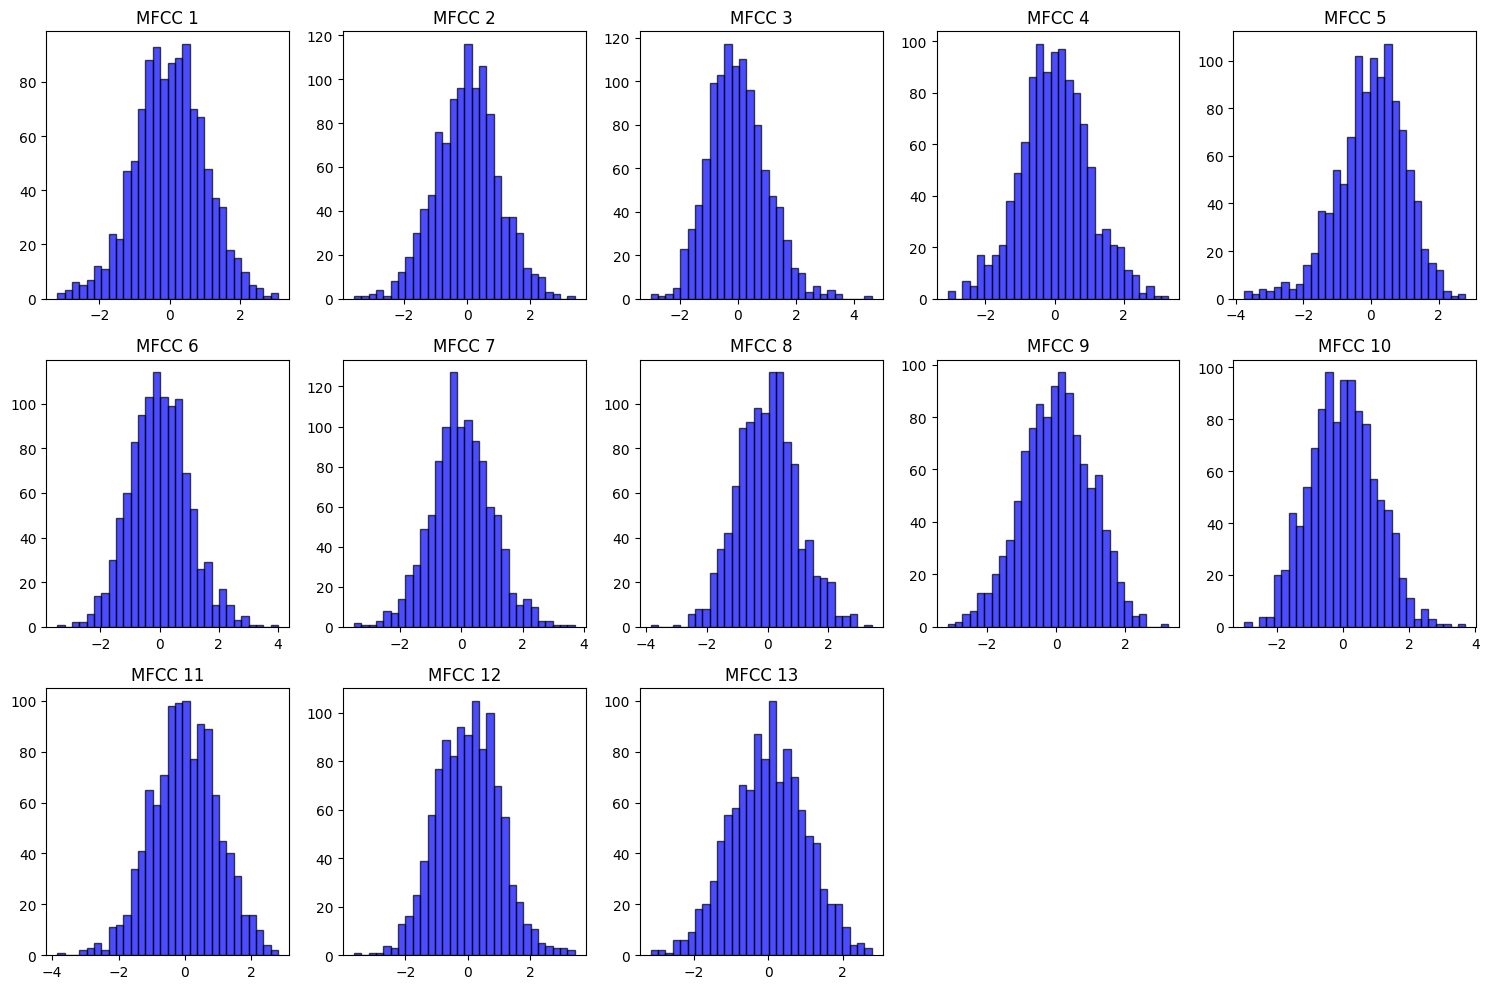

In [64]:
plt.figure(figsize=(15, 10))
for i in range(13):
    plt.subplot(3, 5, i + 1)
    plt.hist(X_scaled[:, i], bins=30, alpha=0.7, color='b', edgecolor='black')
    plt.title(f'MFCC {i+1}')
plt.tight_layout()
plt.show()

**Boxplot to identify outliers**

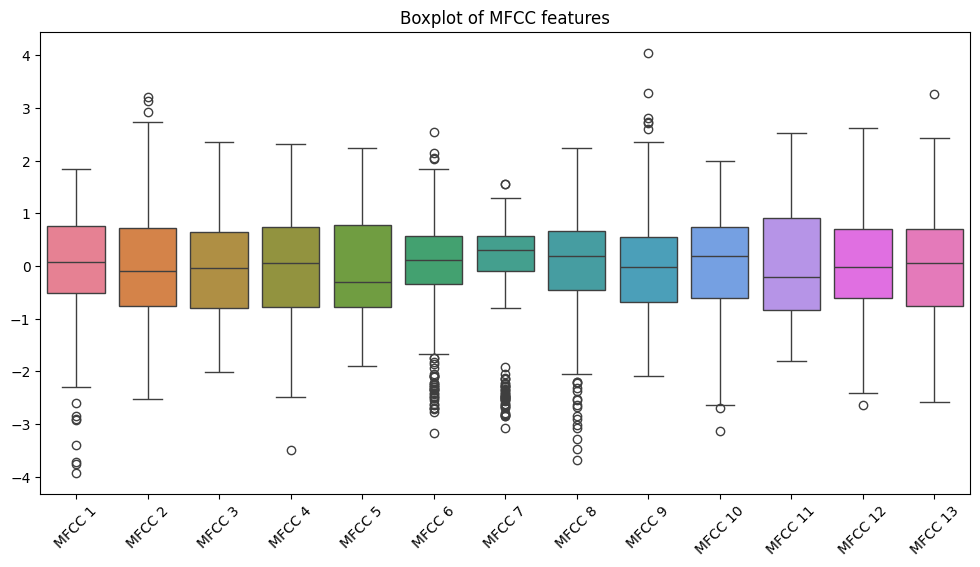

In [53]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_scaled)
plt.xticks(range(13), [f'MFCC {i+1}' for i in range(13)], rotation=45)
plt.title("Boxplot of MFCC features")
plt.show()

**Analysis of the correlation between MFCC and gender**

In [54]:
df_mfcc = pd.DataFrame(X_scaled, columns=[f'MFCC {i+1}' for i in range(13)])
df_mfcc["Gender"] = y

ValueError: Length of values (1103) does not match length of index (349)

In [14]:
print(df_mfcc)

       MFCC 1    MFCC 2    MFCC 3    MFCC 4    MFCC 5    MFCC 6    MFCC 7  \
0   -1.954922  0.481964 -0.845398 -0.893183 -1.097527  1.045647  0.340232   
1   -1.032795  0.081650 -0.916903 -1.307150 -1.039843  1.457469  0.199822   
2   -2.841802 -0.102458 -0.057016 -0.777272 -0.012303  1.836113  0.700816   
3   -1.966681  1.373513 -1.164926 -2.163619 -1.067636  1.565937  0.500838   
4   -2.294826  0.281051 -0.517309 -1.136344 -0.815523  1.178424  0.384622   
..        ...       ...       ...       ...       ...       ...       ...   
344 -0.174921  1.434482 -1.016539  1.128807 -0.274332  0.875113  0.489579   
345 -0.129511  1.748617 -0.987569  2.150723 -0.872740  0.711284  0.605808   
346 -0.152551  2.199865 -0.791112  1.188228 -0.462065  1.627337  0.904343   
347  0.406588  2.373193 -0.690980  0.790904 -1.809055  1.189819  0.783867   
348 -0.399768  1.914588 -0.392158  1.484380 -0.353197  0.826903  0.738229   

       MFCC 8    MFCC 9   MFCC 10   MFCC 11   MFCC 12   MFCC 13 Gender  
0 

In [15]:
summary_stats = df_mfcc.groupby("Gender").agg(["mean", "std"])

In [16]:
print(summary_stats.iloc[:,:14])
print(summary_stats.iloc[:,14:])

          MFCC 1              MFCC 2              MFCC 3              MFCC 4  \
            mean       std      mean       std      mean       std      mean   
Gender                                                                         
F       0.112695  0.903523  0.107379  1.067150 -0.262761  0.758613  0.580456   
M      -0.185264  1.123588 -0.176525  0.857843  0.431964  1.188625 -0.954235   

                    MFCC 5              MFCC 6             MFCC 7            
             std      mean       std      mean       std     mean       std  
Gender                                                                       
F       0.691648 -0.210528  0.686001 -0.339652  1.013001 -0.31239  1.129933  
M       0.632228  0.346096  1.301560  0.558367  0.683273  0.51355  0.362695  
          MFCC 8              MFCC 9             MFCC 10             MFCC 11  \
            mean       std      mean       std      mean       std      mean   
Gender                                           

**distribution of MFCCs by gender**

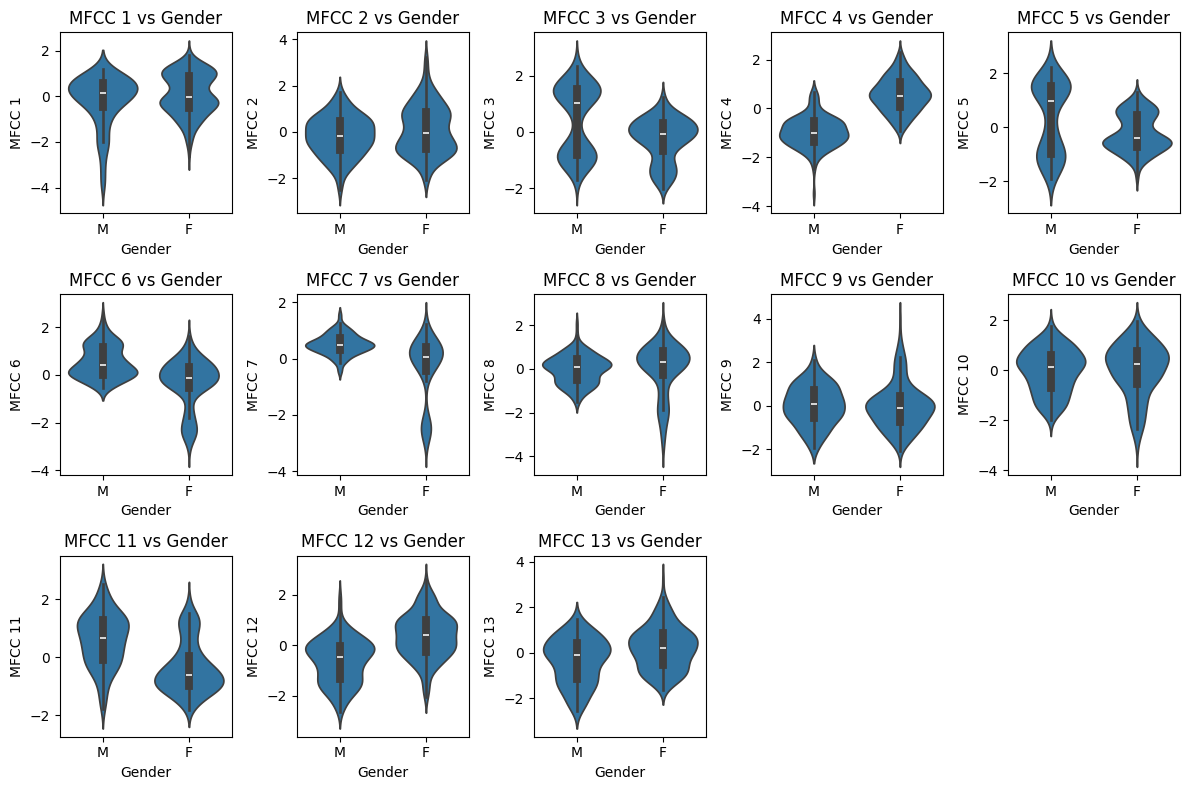

In [17]:
plt.figure(figsize=(12, 8))
for i in range(13):
    plt.subplot(3, 5, i + 1)
    sns.violinplot(x="Gender", y=f"MFCC {i+1}", data=df_mfcc)
    plt.title(f'MFCC {i+1} vs Gender')
plt.tight_layout()
plt.show()

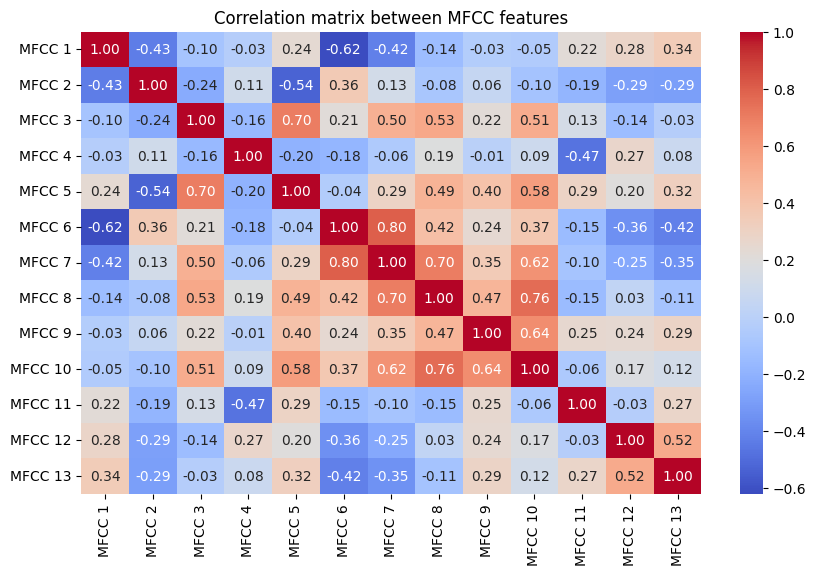

In [18]:
plt.figure(figsize=(10, 6))
corr_matrix = df_mfcc.iloc[:, :-1].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix between MFCC features")
plt.show()

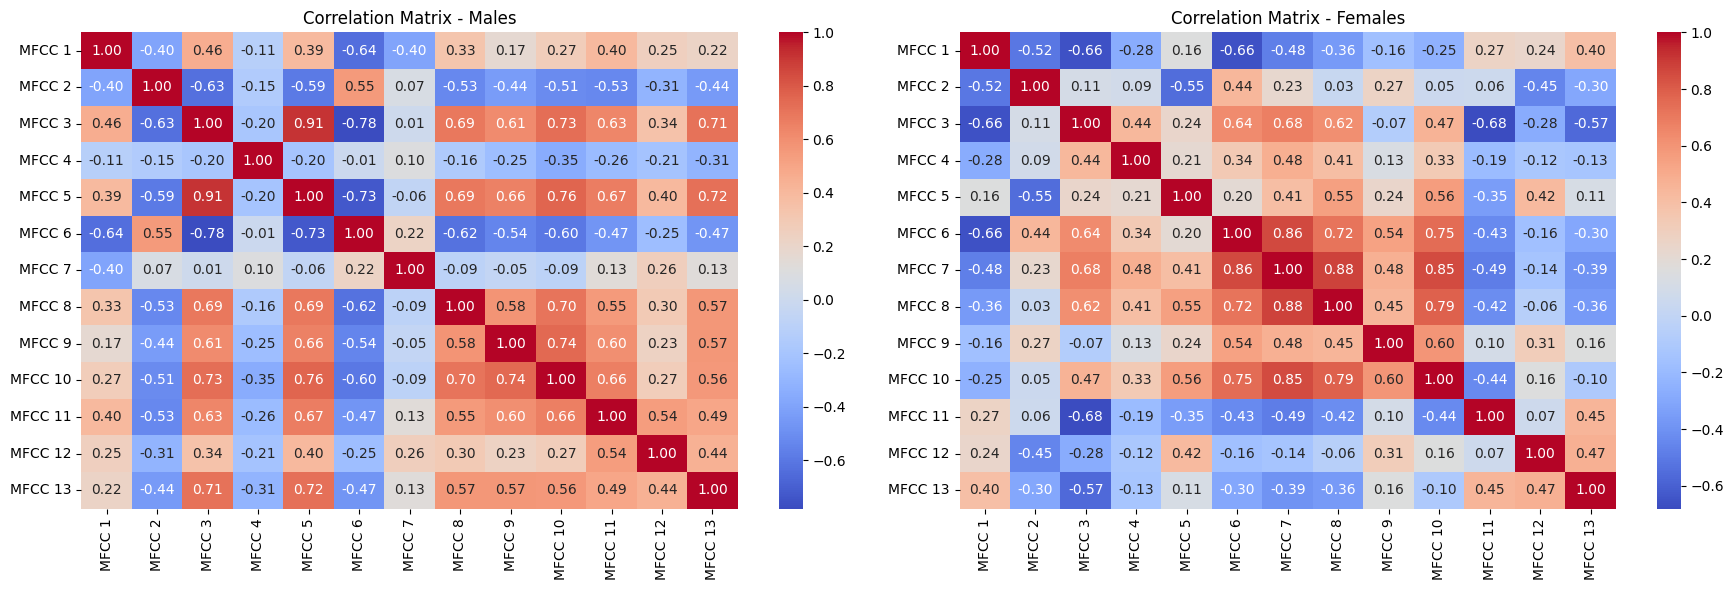

In [19]:
corr_matrix_male = df_mfcc[df_mfcc["Gender"] == "M"].iloc[:, :-1].corr()
corr_matrix_female = df_mfcc[df_mfcc["Gender"] == "F"].iloc[:, :-1].corr()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.heatmap(corr_matrix_male, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0])
axes[0].set_title("Correlation Matrix - Males")

sns.heatmap(corr_matrix_female, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1])
axes[1].set_title("Correlation Matrix - Females")

plt.tight_layout()
plt.show()

In [52]:
encoder = LabelEncoder()

y_encoded = encoder.fit_transform(y)
print(y, y_encoded)

# Split the dataset into training and testing sets (80% train, 20% test)
# Stratification ensures the class distribution is maintained in both sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")


['174' '174' '174' ... '1988' '1988' '1988'] [3 3 3 ... 5 5 5]


ValueError: Found input variables with inconsistent numbers of samples: [349, 1103]

## Models

In [21]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (279, 13), Test set: (70, 13)


**Naïve baseline → Logistic Regression**

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred_log = log_reg.predict(X_test)

**Sophisticated baseline → Support Vector Machine (SVM)**

In [23]:
from sklearn.svm import SVC

svm = SVC(kernel="linear", C=1)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

**Neural Network (MLP) → Multi-Layer Perceptron**

In [24]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation="relu", solver="adam", max_iter=500)
mlp.fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)

**Deep Learning Model (CNN) → Convolutional Neural Network**

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

X_train_cnn = X_train.reshape(X_train.shape[0], 13, 1, 1)
X_test_cnn = X_test.reshape(X_test.shape[0], 13, 1, 1)

cnn_model = keras.Sequential([
    layers.Conv2D(32, (3, 1), activation='relu', input_shape=(13, 1, 1)),
    layers.MaxPooling2D((2, 1)),
    layers.Conv2D(64, (3, 1), activation='relu'),
    layers.MaxPooling2D((2, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.6451 - loss: 0.6712 - val_accuracy: 0.6286 - val_loss: 0.6190
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6420 - loss: 0.6191 - val_accuracy: 0.8000 - val_loss: 0.5591
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8082 - loss: 0.5369 - val_accuracy: 0.9000 - val_loss: 0.4741
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9666 - loss: 0.4319 - val_accuracy: 0.9857 - val_loss: 0.3695
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9866 - loss: 0.3340 - val_accuracy: 0.9571 - val_loss: 0.2610
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9948 - loss: 0.2188 - val_accuracy: 0.9857 - val_loss: 0.1773
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9809 - loss: 0.1414 - val_accuracy: 0.9857 - val_loss: 0.1166
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9934 - loss: 0.1113 - val_accuracy: 0.9857 - val_loss: 0.0874
Epo

**REPORT**

In [51]:
from sklearn.metrics import classification_report

report_log_reg = classification_report(y_test, y_pred_log, output_dict=True)
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)
report_mlp = classification_report(y_test, y_pred_mlp, output_dict=True)

y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype("int32")
report_cnn = classification_report(y_test, y_pred_cnn, output_dict=True)

df_log_reg = pd.DataFrame(report_log_reg).transpose()
df_svm = pd.DataFrame(report_svm).transpose()
df_mlp = pd.DataFrame(report_mlp).transpose()
df_cnn = pd.DataFrame(report_cnn).transpose()

ValueError: Found input variables with inconsistent numbers of samples: [221, 70]

In [27]:
print("Logistic Regression Report:\n", df_log_reg)
print("\nSVM Report:\n", df_svm)

Logistic Regression Report:
               precision  recall  f1-score  support
0                   1.0     1.0       1.0     44.0
1                   1.0     1.0       1.0     26.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     70.0
weighted avg        1.0     1.0       1.0     70.0

SVM Report:
               precision    recall  f1-score    support
0              1.000000  0.977273  0.988506  44.000000
1              0.962963  1.000000  0.981132  26.000000
accuracy       0.985714  0.985714  0.985714   0.985714
macro avg      0.981481  0.988636  0.984819  70.000000
weighted avg   0.986243  0.985714  0.985767  70.000000


In [28]:
print("\nMLP Report:\n", df_mlp)
print("\nCNN Report:\n", df_cnn)


MLP Report:
               precision    recall  f1-score    support
0              1.000000  0.977273  0.988506  44.000000
1              0.962963  1.000000  0.981132  26.000000
accuracy       0.985714  0.985714  0.985714   0.985714
macro avg      0.981481  0.988636  0.984819  70.000000
weighted avg   0.986243  0.985714  0.985767  70.000000

CNN Report:
               precision    recall  f1-score    support
0              1.000000  0.977273  0.988506  44.000000
1              0.962963  1.000000  0.981132  26.000000
accuracy       0.985714  0.985714  0.985714   0.985714
macro avg      0.981481  0.988636  0.984819  70.000000
weighted avg   0.986243  0.985714  0.985767  70.000000


In [29]:
import pickle
file_path = "/content/drive/MyDrive/Voiseed_task/df_sampled.pkl"
with open(file_path, "wb") as f:
    pickle.dump(df_sampled, f)

# Part 2

In [30]:
import librosa
import numpy as np
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
model_name = "facebook/wav2vec2-base-960h"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [32]:
with open(file_path, "rb") as f:
    df_sampled = pickle.load(f)
print(df_sampled.head())

  Speaker_ID Gender     Subset
0        174      M  dev-clean
1        251      M  dev-clean
2        422      M  dev-clean
3        652      M  dev-clean
4        777      M  dev-clean


In [33]:
def extract_wav2vec_features(file_path, model, processor, chunk_duration=2.0, sr=16000):
    """
    Extracts Wav2Vec2 embeddings from an audio file.

    - Splits the audio into fixed-length chunks (default: 2 seconds).
    - Processes each chunk with Wav2Vec2 to generate feature embeddings.
    - Returns an array of extracted features.
    """

    # Load the audio file with the specified sampling rate
    y, _ = librosa.load(file_path, sr=sr)

    # Define chunk size in samples
    chunk_size = int(sr * chunk_duration)

    # Split the audio into consecutive chunks of fixed size
    chunks = [y[i:i+chunk_size] for i in range(0, len(y), chunk_size) if len(y[i:i+chunk_size]) == chunk_size]

    features = []
    for chunk in chunks:
        # Convert audio chunk to input format for Wav2Vec2
        inputs = processor(chunk, return_tensors="pt", sampling_rate=sr).input_values.to(device)

        # Extract embeddings from the Wav2Vec2 model
        with torch.no_grad():
            embeddings = model(inputs).last_hidden_state.mean(dim=1).cpu().numpy()

        # Store flattened embeddings
        features.append(embeddings.flatten())

    return np.array(features)

features = []
labels = []

In [34]:
# Iterate through the sampled dataset to extract features from each speaker's audio files
for _, row in df_sampled.iterrows():
    speaker_id = row["Speaker_ID"]
    speaker_label = speaker_id  # Speaker ID is used as the class label

    # Construct path to the speaker's folder
    speaker_folder = os.path.join(audio_dir, str(speaker_id))

    # Iterate through chapters within the speaker's folder
    for chapter in os.listdir(speaker_folder):
        chapter_folder = os.path.join(speaker_folder, chapter)

        # Iterate through audio files in the chapter
        for file in os.listdir(chapter_folder):
            if file.endswith(".flac"):  # Process only FLAC audio files
                audio_file_path = os.path.join(chapter_folder, file)

                # Extract Wav2Vec2 features from the audio file
                emb = extract_wav2vec_features(audio_file_path, model, processor)

                # Store extracted embeddings and corresponding speaker label
                for e in emb:
                    features.append(e)
                    labels.append(speaker_label)

X = np.array(features)
y = np.array(labels)

print(f"Extracted Features Shape: {X.shape}, Labels Shape: {y.shape}")

Extracted Features Shape: (1103, 768), Labels Shape: (1103,)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (882, 768), Test set: (221, 768)


In [36]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# SVM
svm = SVC(kernel="linear", C=1)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("\nRandom Forest:\n", classification_report(y_test, y_pred_rf))
print("\nSVM:\n", classification_report(y_test, y_pred_svm))


Random Forest:
               precision    recall  f1-score   support

        1272       0.43      0.49      0.45        41
        1462       0.50      0.49      0.49        41
        1673       0.55      0.64      0.59        44
         174       0.37      0.36      0.37        44
        1919       0.40      0.38      0.39        42
        1988       0.00      0.00      0.00         9

    accuracy                           0.45       221
   macro avg       0.37      0.39      0.38       221
weighted avg       0.43      0.45      0.44       221


SVM:
               precision    recall  f1-score   support

        1272       0.52      0.61      0.56        41
        1462       0.69      0.54      0.60        41
        1673       0.59      0.66      0.62        44
         174       0.51      0.52      0.52        44
        1919       0.54      0.60      0.57        42
        1988       1.00      0.11      0.20         9

    accuracy                           0.57       221

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


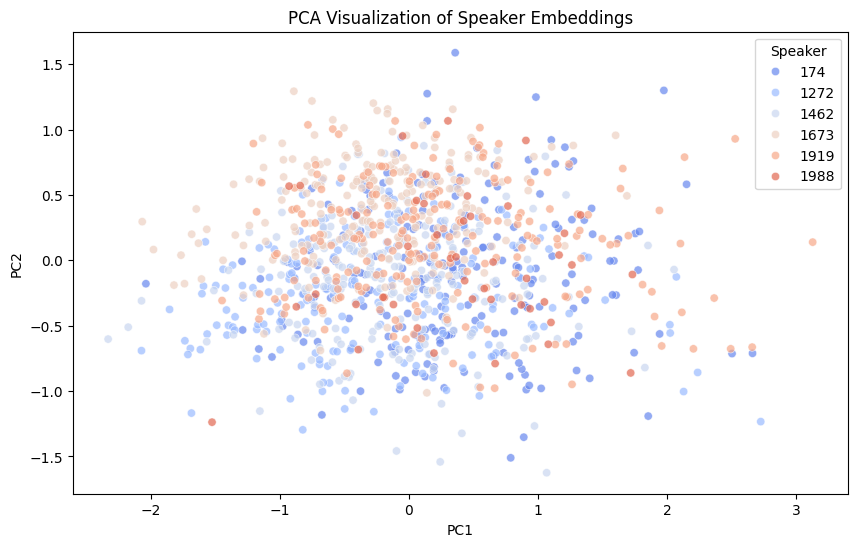

In [37]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Speaker"] = y

plt.figure(figsize=(10, 6))
sns.scatterplot(x="PC1", y="PC2", hue="Speaker", palette="coolwarm", data=df_pca, alpha=0.7)
plt.title("PCA Visualization of Speaker Embeddings")
plt.show()


Github Repo

In [38]:
%cd /content/drive/MyDrive/
!git clone https://github.com/LosaLosSantos/Speaker-Classification.git

/content/drive/MyDrive
fatal: destination path 'Speaker-Classification' already exists and is not an empty directory.


In [43]:
%cd /content/drive/MyDrive/Speaker-Classification

/content/drive/MyDrive/Speaker-Classification


In [40]:
import shutil

source_dir = "/content/drive/MyDrive/Voiseed_task/"
repo_dir = "/content/drive/MyDrive/Speaker-Classification/"

shutil.copy(source_dir + "DSP.ipynb", repo_dir + "DSP.ipynb")
shutil.copy(source_dir + "df_sampled.pkl", repo_dir + "df_sampled.pkl")
shutil.copy(source_dir + "LibriSpeech/SPEAKERS.TXT", repo_dir + "SPEAKERS.TXT")

'/content/drive/MyDrive/Speaker-Classification/SPEAKERS.TXT'

In [49]:
!git add .
!git commit -m "1"

[main 949d93a] 1
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite DSP.ipynb (89%)


In [50]:
!git push origin main

Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 3.30 KiB | 105.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/LosaLosSantos/Speaker-Classification.git
   389e813..949d93a  main -> main
